# Regression for predicting continuous variables

**Regression models** are used to predict target variables on a continuous scale.

## Introducing a simple regression model

Our goal is to model the relationship between a single feature (explanatory variable x) and a response (target variable y). The well known equation of a linear model is:

$$
y = w_0 + w_1x
$$

$w_0$ represents the y axis intercept and $w_1$ is the coefficient of the explanatory variable. We can easily generalize the equation to get a **multiple linear regression**:

$$
y = w_0x_0+w_1x_1+...+w_mx_m=\sum_{i=0}^{m}w_ix_i=w^Tx
$$

$w_0$ is the y axis intercept with $x_0=1$.

## Exploring the housing dataset

We will work with the **Boston housing dataset**. We will try to predict **MEDV** which is the median value of homes in 1000$.

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Visualizing data

Data visualization is the key through exploratory analysis. First, we will create a *scatterplot matrix* to inspect pairwise correlations. To do this we will use the [**pairplot**](http://seaborn.pydata.org/generated/seaborn.pairplot.html) function from the **seaborn** library.

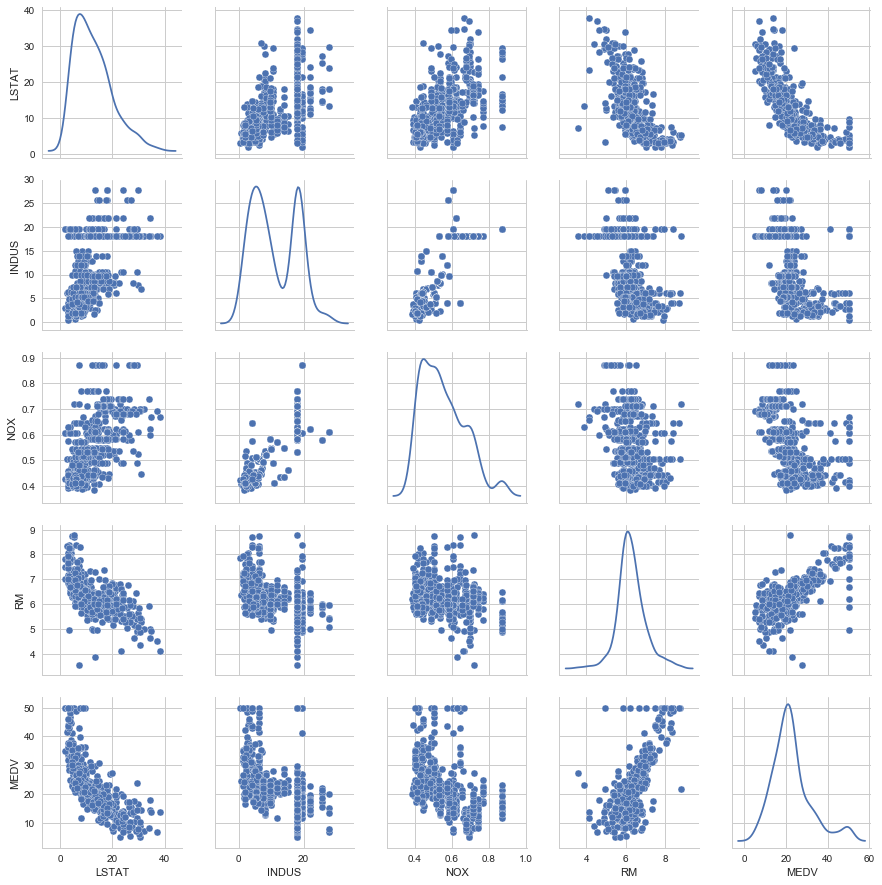

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], diag_kind='kde')
plt.show()

Let's now plot a correlation matrix

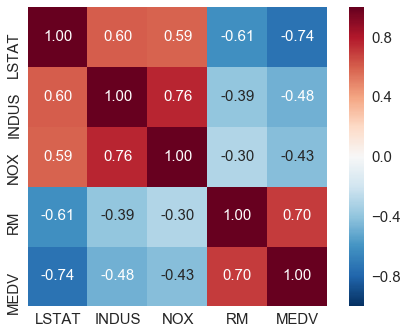

In [14]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)

sns.set(font_scale=1.5)

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

## Implementing ordinary least squares

With **OLS (Ordinary Least Squares)** we can fit a simple linear regression.

### Solving regression with gradient descent

This is basically the same as in **ADAline**, we want to minimize the **SSE (Sum of Squared Errors)**

$$
J(w)=\frac{1}{2}\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2
$$

In [15]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, x, y):
        self.w_ = np.zeros(1 + x.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(x)
            errors = (y - output)
            self.w_[1:] += self.eta * x.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, x):
        return np.dot(x, self.w_[1:]) + self.w_[0]
    
    def predict(self, x):
        return self.net_input(x)

To see how our **LinearRegressionGD** behave let's test it with the number of rooms (**RM**) variable. For better convergence we will standardize the variables.

In [19]:
x = df[['RM']].values
y = df['MEDV'].values

In [20]:
from sklearn.preprocessing import StandardScaler

In [25]:
sc_x = StandardScaler()
sc_y = StandardScaler()
x_std = sc_x.fit_transform(x)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(x_std, y_std)

Now let's plot the SSE against the number of epochs

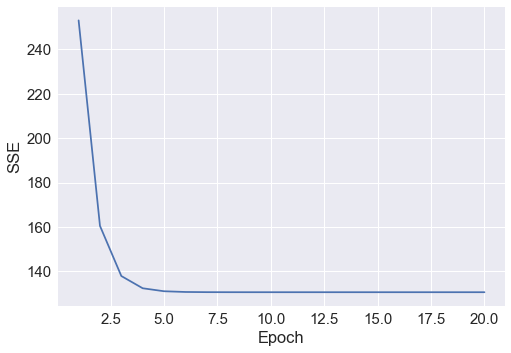

In [31]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

As we can see the algorithm converged after the 5th epoch. Next we want to visualize how well the regression line fits the data.

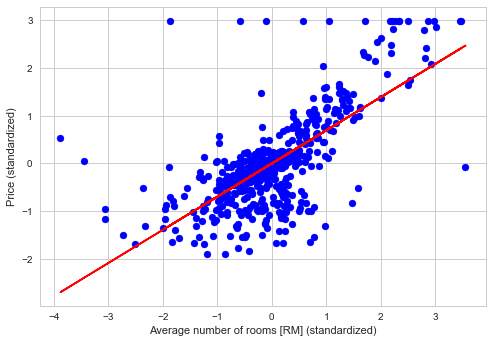

In [33]:
def lin_regplot(x, y, model):
    plt.scatter(x, y, c='blue')
    plt.plot(x, model.predict(x), color='red')
    return None

sns.set(style='whitegrid', context='notebook')

lin_regplot(x_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price (standardized)')
plt.show()

The line explains the overall trend well, but it's clear that it can't explain the prices very well.

Now let's transform back the data to their original scales for reporting.

In [39]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


### Regression with scikit-learn

By using [**LinearRegression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from scikit-learn we get improved performance and better algorithms that work better with unstandardized variables.